In [1]:
#載入所需函示庫

from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 80
import seaborn as sns

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
import math
import statistics
import itertools
from statsmodels.tsa.api import Holt
from scipy.optimize import curve_fit

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [85]:
def objective(x, a, b, c):
    return a * x + b * x**2 + c

def scatter_plot(x, y, data):
    y_var = data[y].values
    for i, aname in enumerate(x):
        x_var = data[aname].values
        _ = sns.regplot(x = x_var, y = y_var, color = 'b', ci = None)
        plt.title('Scatter Plot for '+y +' and ' +aname)
        plt.ylabel(y)
        
        plt.xlabel(aname)
        plt.show()
    

def scatter_plot_2nd(x, y, data):
    y_var = data[y].values
    color = ['r', 'b', 'g', 'c', 'm', 'y']
    for i, aname in enumerate(x):
        x_var = data[aname].values
        popt, _ = curve_fit(objective, x_var, y_var)
        a, b, c = popt
        print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
        plt.scatter(x_var, y_var, color = color[i], label=aname)
        x_line = np.arange(min(x_var), max(x_var), 0.1)
        y_line = objective(x_line, a, b, c)
        plt.plot(x_line, y_line, '--', color=color[i])
    plt.ylabel(y)
    plt.legend()
    plt.show()

In [66]:
def forward_selection(input_df, depv="y", indepv = ["x1"]):
    selected = []
    candidates = indepv.copy()
    best_adjr2 = -1
    best_subset = []
    while len(candidates) > 0:
        print("Current Candidates: ", candidates)
        tmp_indep_subset = []
        tmp_model_adjr = []
        tmp_model_nindep = []
        for acandidate in candidates:
            tmplist = selected.copy()
            tmplist.append(acandidate)
            modelstr = depv + " ~ " + "+".join(tmplist)
            result6tmp = smf.ols(modelstr, data=input_df).fit()
            tmp_indep_subset.append(tmplist)
            tmp_model_adjr.append(result6tmp.rsquared_adj)
            tmp_model_nindep.append(len(tmplist))
        tmp_adjr2 = np.array(tmp_model_adjr)
        tmpind = tmp_adjr2.argmax()
        this_adjr2 = tmp_adjr2[tmpind]
        selected = tmp_indep_subset[tmpind]
        if this_adjr2 <= 0:
            raise("Encounterd negative Adj R2. Stop.")
        print("===============")
        print("Current best model: ", selected)
        print("Current best AdjR2: ", this_adjr2)
        if this_adjr2 > best_adjr2:
            #print(" best result updated")
            best_adjr2 = this_adjr2
            best_subset = selected
        candidates = set(candidates) - set(selected)
        candidates = list(candidates)
    print("best_adjr2 = ", best_adjr2)
    print("best_subset = ", best_subset)
    modelstr = depv + " ~ " + "+".join(best_subset)
    result6b = smf.ols(modelstr, data=input_df).fit()
    print(result6b.summary()) 
    return result6b

In [69]:
def CI_PI_regression(xdata, yval, x1, a):
    
    X_data_T = xdata.T
    X_data2 = sm.add_constant(X_data_T)
    olsmod = sm.OLS(yval, X_data2)
    result_reg = olsmod.fit()
    y_head = np.dot(result_reg.params, x1)
    
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    core1 = (result_reg.mse_resid * np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1))) ** 0.5

    lower_bound = y_head +  t_minus * core1
    upper_bound = y_head +  t_plus * core1
    
    core2 = (result_reg.mse_resid * (1 + np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1)))) ** 0.5
    lower_bound2 = y_head +  t_minus * core2
    upper_bound2 = y_head +  t_plus * core2
    
    CI = [lower_bound, upper_bound]
    PI = [lower_bound2, upper_bound2]
    return CI, PI

### 批改符號:
- H 表沒有寫H0H1，或前面寫了雙尾的H0H1，但那題是要用單尾，不確定的話可以參考參考解答。
- R 表沒有寫reject H0 or not.
- 被畫一個大圈-3 表沒畫散佈圖

### Model 是否 valid:
- 以 F-test 的結果為主
- 若 F-test 結論為 valid ，但有做殘差分析、檢查多元共線性等發現 not valid，只要原因合理都給對。

### 兩個 Model 比較:
- 以 standard error 和 adjusted R2 為主。
- 大多人都只寫R2，完全沒提到 standard error 的話-1，如果前面有列出各自的 standard error 但最後沒比較則不扣分。
- 如果做殘差分析、檢查多元共線性發現與standard error 和 adjusted R2 的結論相反，只要原因合理都給對。

### 18.5(second-order), 18.7, 18.49:
- 因為題目本身沒有說要處理多元共線性、second order等問題，所以如果單純用原本的資料沒有多加處理也給對。
- 如果照老師的步驟判斷問題並處理 (eg原資料- mean等)，寫出處理後的model也給對。

### 檢驗單一independent variable的影響:
- 必須用檢定的方式，不可以只用係數的正負判斷
- 部分檢驗為單尾，不可以只做雙尾檢定+用係數判斷方向就下對單尾檢定的結論，必須算出單尾的pvalue

### 18.19
- 由於 codes_3可直接以codes_1, codes_2表示，故不應該放入模型中。

### 18.36
- 是example 18.4，注意資料用對
- 必須自己調整過weight，不可直接使用原資料內的score
- 如果被寫weight? 表示是用原資料內的score，整大題錯（也可能是我沒看到你調整weight的過程，可以再寄信跟我確認）
- 題目有要求要下conclusion，可以根據係數說明你從model得到的結論。

### 18.49
- 由於題目沒有規定independent variable，所以各種second order, interaction, stepwise的方法都給對
- 但有幾種問題一定算錯：
- 1. 直接用原始Weather值，原本的weather值始能表示類別，甚至沒有排序關係，不可直接使用
- 2. 把weather分成weather_1, weaher_2, weather_3，由於 weather_3可直接以weather_1, weaher_2表示，故不應該放入模型中。


# 18.5 (18%)  
### (a)散佈圖3% equation3%，(b)散佈圖3% equation3%，(c)3%，(d)3%

In [126]:
df18_5 = pd.read_excel("Xr18-05.xlsx")
print('Dataset(head):')
display(df18_5.head())
print('Dataset(tail):')
display(df18_5.tail())

Dataset(head):


,Time,Day
0,40,1
1,41,2
2,36,3
3,38,4
4,33,5


Dataset(tail):


,Time,Day
5,32,6
6,30,7
7,32,8
8,29,9
9,30,10


## First Order   
Independent variable: Day(X1)  
Dependent variable (y): Time  

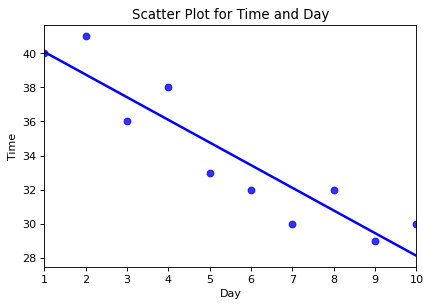

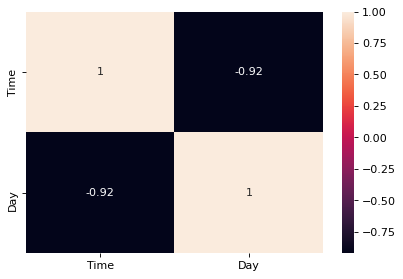

In [127]:
scatter_plot(["Day"], "Time", df18_5)
corr5b = df18_5.corr()
_ = sns.heatmap(corr5b, annot=True)

According to the scatter plot, it seems to be a linear relationship between Day and Time.

### (a) Equation

In [128]:
df18_5_result1 = smf.ols('Time~ Day', data=df18_5).fit()
print(df18_5_result1.summary())

b1_1 = df18_5_result1.params[1]
b0_1 = df18_5_result1.params[0]
print("Estimated model: y = %0.4f + %0.4f x" % (b0_1, b1_1))

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     45.48
Date:                Tue, 17 May 2022   Prob (F-statistic):           0.000146
Time:                        03:17:10   Log-Likelihood:                -18.882
No. Observations:                  10   AIC:                             41.76
Df Residuals:                       8   BIC:                             42.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.4000      1.221     33.902      0.0

### (b) F-test
H0: All betas = 0  
H1: At least one of the betas != 0  
Since F = 45.48, p-value = 0.0001 < alpha = 0.05, we reject H0. The model is valid. 

## Second Order  
Independent variable: Day(X1), Day^2(X2)  
Dependent variable (y): Time  


### (a) Equation

y = -2.49394 * x + 0.10606 * x^2 + 43.73333


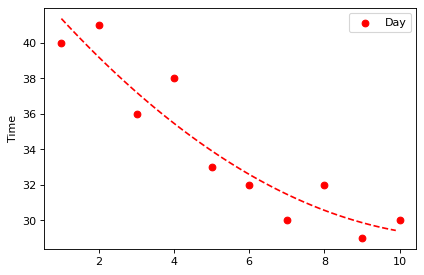

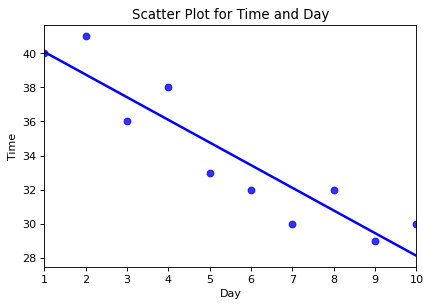

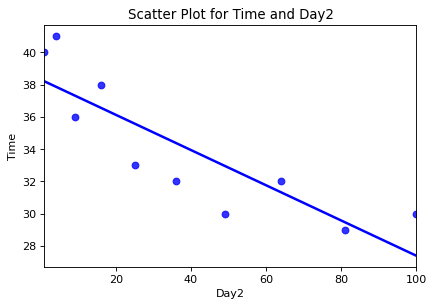

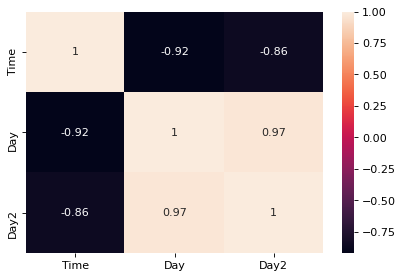

In [129]:
df18_5['Day2'] = df18_5['Day'] ** 2
scatter_plot_2nd(["Day"], "Time", df18_5)
scatter_plot(df18_5.columns[1:], "Time", df18_5)

corr5b = df18_5.corr()
_ = sns.heatmap(corr5b, annot=True)

According to the scatter plot, it seems to be a linear relationship between Day and Time.

In [130]:
y_data = df18_5['Time']
X_data_ar = np.array([df18_5['Day'], df18_5['Day2']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df18_5.columns[1:])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
df18_5_result2 = olsmod.fit()
print(df18_5_result2.summary())

b2_2 = df18_5_result2.params[2]
b1_2 = df18_5_result2.params[1]
b0_2 = df18_5_result2.params[0]
print("\nEstimated model: y = %0.4f + %0.4f x + %0.4f x2" % (b0_2, b1_2, b2_2))

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     26.98
Date:                Tue, 17 May 2022   Prob (F-statistic):           0.000513
Time:                        03:17:17   Log-Likelihood:                -17.560
No. Observations:                  10   AIC:                             41.12
Df Residuals:                       7   BIC:                             42.03
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.7333      1.969     22.208      0.0

Since there is issue of multicollinearity, we modify the original predictor variables by day = day - mean(day)

In [131]:
df18_5['Day'] = df18_5['Day']-df18_5['Day'].mean()
df18_5['Day2'] = df18_5['Day'] ** 2
print('Dataset(head):')
display(df18_5.head())
print('Dataset(tail):')
display(df18_5.tail())

Dataset(head):


,Time,Day,Day2
0,40,-4.5,20.25
1,41,-3.5,12.25
2,36,-2.5,6.25
3,38,-1.5,2.25
4,33,-0.5,0.25


Dataset(tail):


,Time,Day,Day2
5,32,0.5,0.25
6,30,1.5,2.25
7,32,2.5,6.25
8,29,3.5,12.25
9,30,4.5,20.25


y = -1.32727 * x + 0.10606 * x^2 + 33.22500


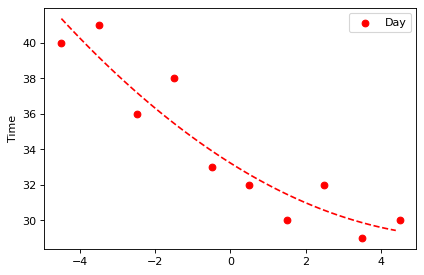

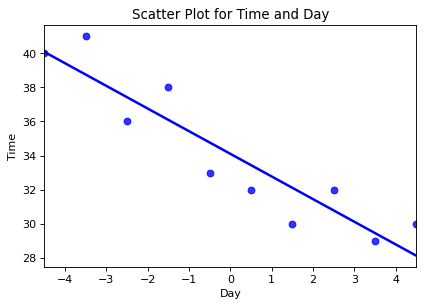

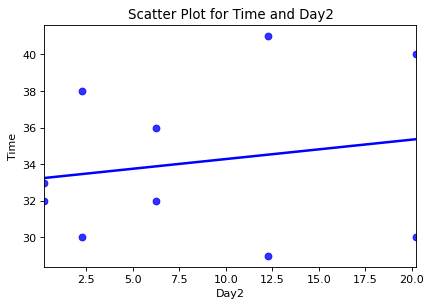

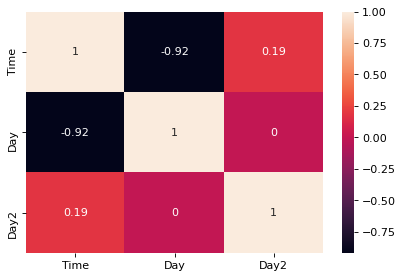

In [132]:
scatter_plot_2nd(["Day"], "Time", df18_5)
scatter_plot(df18_5.columns[1:], "Time", df18_5)

corr5b = df18_5.corr()
_ = sns.heatmap(corr5b, annot=True)

In [133]:
y_data = df18_5['Time']
X_data_ar = np.array([df18_5['Day'], df18_5['Day2']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df18_5.columns[1:])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
df18_5_result2 = olsmod.fit()
print(df18_5_result2.summary())

b2_2 = df18_5_result2.params[2]
b1_2 = df18_5_result2.params[1]
b0_2 = df18_5_result2.params[0]
print("\nEstimated model: y = %0.4f + %0.4f x + %0.4f x2" % (b0_2, b1_2, b2_2))

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     26.98
Date:                Tue, 17 May 2022   Prob (F-statistic):           0.000513
Time:                        03:17:25   Log-Likelihood:                -17.560
No. Observations:                  10   AIC:                             41.12
Df Residuals:                       7   BIC:                             42.03
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.2250      0.801     41.475      0.0

### (b) F-test
H0: All betas = 0  
H1: At least one of the betas != 0  
Since F = 26.98, p-value = 0.0005 < alpha = 0.05, we reject H0. The model is valid.
### (c) Assessment

In [134]:
print("standard error of 1st order = ", df18_5_result1.mse_resid ** 0.5)
print("standard error of 2nd order = ", df18_5_result2.mse_resid ** 0.5)
print('\n')
print("adjusted r^2  of 1st order = ", df18_5_result1.rsquared_adj)
print("adjusted r^2  of 2nd order = ", df18_5_result2.rsquared_adj)

standard error of 1st order =  1.7875834373406314
standard error of 2nd order =  1.6743545632461476


adjusted r^2  of 1st order =  0.8317197723283153
adjusted r^2  of 2nd order =  0.8523629676350568


The second–order model is better because its adjusted r^2 is higher and its standard error of estimate is smaller.

# 18.7 (9%) 
### 散佈圖3%，(a)3%，(b)3%

Independent variable: Home %(X1), Visiting %(X2), Home_Visiting(X3)  
Dependent variable (y): Attendance

In [135]:
df18_7 = pd.read_excel("Xr18-07.xlsx")
print('Dataset(head):')
display(df18_7.head())
print('Dataset(tail):')
display(df18_7.tail())

Dataset(head):


,Attendance,Home %,Visiting %
0,14067,0.491,0.422
1,52488,0.563,0.574
2,12693,0.445,0.400
3,35954,0.544,0.539
4,36452,0.479,0.501


Dataset(tail):


,Attendance,Home %,Visiting %
35,26265,0.509,0.445
36,21668,0.458,0.434
37,24446,0.459,0.421
38,15316,0.404,0.425
39,49406,0.574,0.526


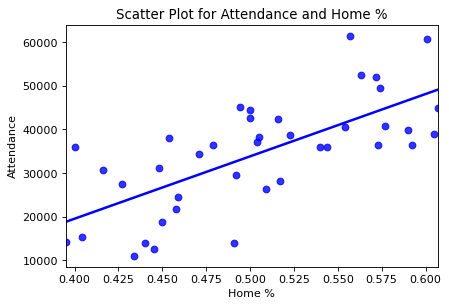

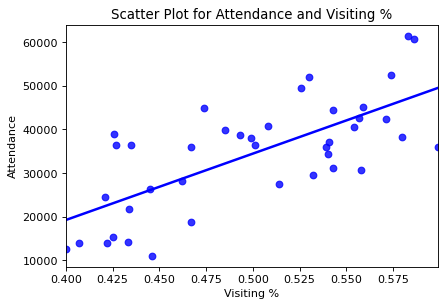

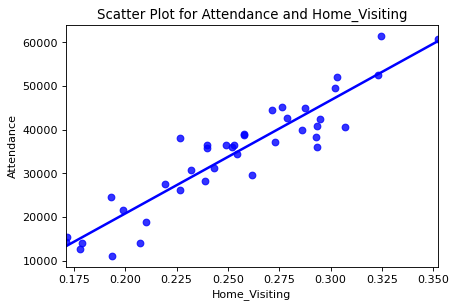

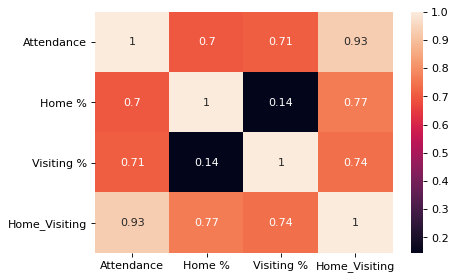

In [136]:
df18_7['Home_Visiting'] = df18_7['Home %'] * df18_7['Visiting %']
scatter_plot(df18_7.columns[1:], "Attendance", df18_7)

corr7b = df18_7.corr()
_ = sns.heatmap(corr7b, annot=True)

According to the scatter plot, all independent variables seem to have a linear relationship with Attendance.

In [137]:
y_data = df18_7['Attendance']
X_data_ar = np.array([df18_7['Home %'], df18_7['Visiting %'], df18_7['Home_Visiting']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df18_7.columns[1:])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
df18_7_result = olsmod.fit()
print(df18_7_result.summary())

b2 = df18_7_result.params[2]
b1 = df18_7_result.params[1]
b0 = df18_7_result.params[0]
print("\nEstimated model: y = %0.4f + %0.4f x + %0.4f x2" % (b0, b1, b2))

                            OLS Regression Results                            
Dep. Variable:             Attendance   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     80.65
Date:                Tue, 17 May 2022   Prob (F-statistic):           4.82e-16
Time:                        03:17:37   Log-Likelihood:                -393.24
No. Observations:                  40   AIC:                             794.5
Df Residuals:                      36   BIC:                             801.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -8.204e+04   4.85e+04     -1.691

Since there is issue of multicollinearity, we modify the original predictor variables by Home = Home - mean(Home) and Visiting = Visiting-mean(Visiting)

In [138]:
df18_7['Home %'] = df18_7['Home %']-df18_7['Home %'].mean()
df18_7['Visiting %'] = df18_7['Visiting %']-df18_7['Visiting %'].mean()
df18_7['Home_Visiting'] = df18_7['Home %'] * df18_7['Visiting %']
print('Dataset(head):')
display(df18_7.head())
print('Dataset(tail):')
display(df18_7.tail())

Dataset(head):


,Attendance,Home %,Visiting %,Home_Visiting
0,14067,-0.0135,-0.07815,0.001055
1,52488,0.0585,0.07385,0.004320
2,12693,-0.0595,-0.10015,0.005959
3,35954,0.0395,0.03885,0.001535
4,36452,-0.0255,0.00085,-0.000022


Dataset(tail):


,Attendance,Home %,Visiting %,Home_Visiting
35,26265,0.0045,-0.05515,-0.000248
36,21668,-0.0465,-0.06615,0.003076
37,24446,-0.0455,-0.07915,0.003601
38,15316,-0.1005,-0.07515,0.007553
39,49406,0.0695,0.02585,0.001797


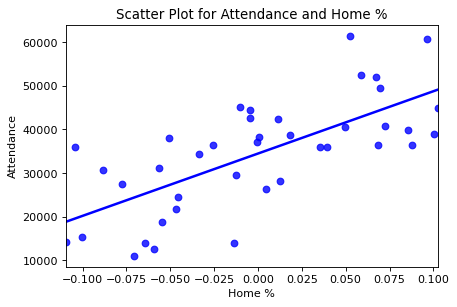

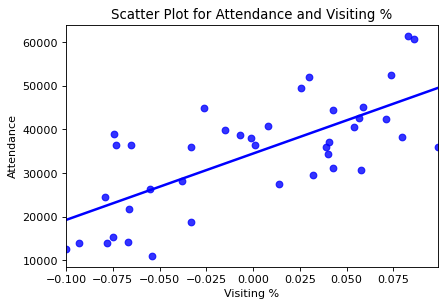

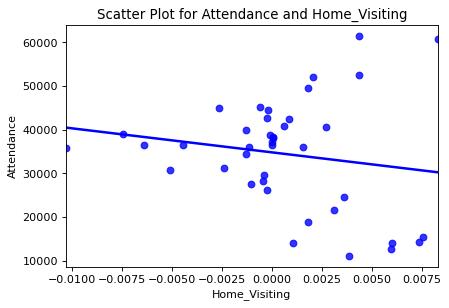

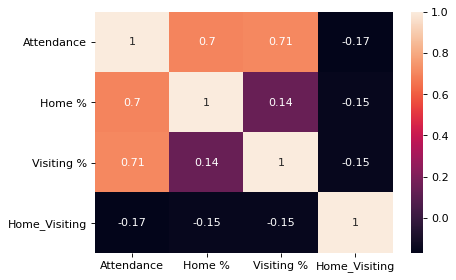

In [120]:
scatter_plot(df18_7.columns[1:], "Attendance", df18_7)
corr7b = df18_7.corr()
_ = sns.heatmap(corr7b, annot=True)

After modifying the independent variables, Home and Visiting seen=m to have linear relationship with Attendance, while Home_Visiting does not.

In [121]:
y_data = df18_7['Attendance']
X_data_ar = np.array([df18_7['Home %'], df18_7['Visiting %'], df18_7['Home_Visiting']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df18_7.columns[1:])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
df18_7_result = olsmod.fit()
print(df18_7_result.summary())

b2 = df18_7_result.params[2]
b1 = df18_7_result.params[1]
b0 = df18_7_result.params[0]
print("\nEstimated model: y = %0.4f + %0.4f x + %0.4f x2" % (b0, b1, b2))

                            OLS Regression Results                            
Dep. Variable:             Attendance   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     80.65
Date:                Tue, 17 May 2022   Prob (F-statistic):           4.82e-16
Time:                        03:15:15   Log-Likelihood:                -393.24
No. Observations:                  40   AIC:                             794.5
Df Residuals:                      36   BIC:                             801.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.445e+04    756.986     45.511

### (b)
H0: All betas = 0  
H1: At least one of the betas != 0  
Since F = 80.65, p-value = 0 < alpha = 0.05, we reject H0. The model is valid.

However, all p-values of independent variables > 0.05.  
None of independent variables has a linear relationship with attendance.  
This implies the issue of multicollonearity.

# 18.19 (18%)
### (a)散佈圖3% Regression model 3%，(b)散佈圖3% Regression model 3%，(c)3%，(d)3%

In [44]:
df18_19 = pd.read_excel("Xr17-12.xlsx")
print('Dataset(head):')
display(df18_19.head())
print('Dataset(tail):')
display(df18_19.tail())

Dataset(head):


,Time,Boxes,Weight,Codes
0,62,126,36.05,3
1,77,154,22.94,2
2,39,96,24.86,3
3,52,127,30.54,1
4,79,151,35.57,2


Dataset(tail):


,Time,Boxes,Weight,Codes
45,36,101,14.86,1
46,77,150,50.02,1
47,63,146,40.83,1
48,50,137,7.50,1
49,59,140,17.30,1


### (a) original codes  
Independent variable: Boxes(X1), Weight(X2), Codes(X3)  
Dependent variable (y): Time

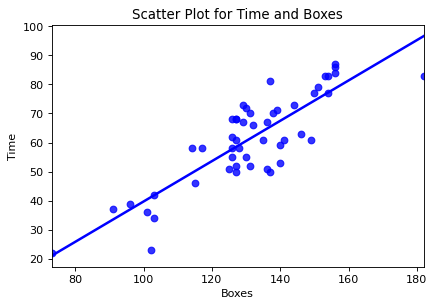

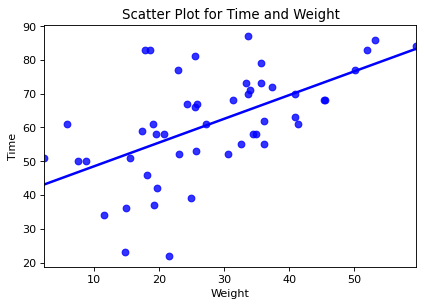

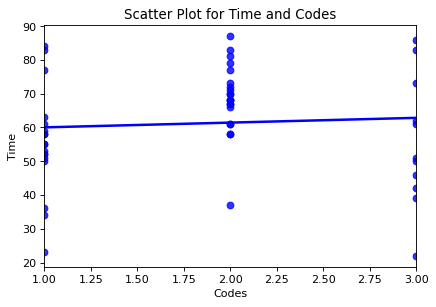

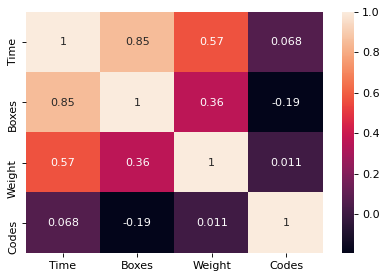

In [87]:
scatter_plot(df18_19.columns[1:], "Time", df18_19)
corr19_a = df18_19.corr()
_ = sns.heatmap(corr19_a, annot=True)

In [46]:
y_data = df18_19['Time']
X_data_ar = np.array([df18_19['Boxes'], df18_19['Weight'], df18_19['Codes']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df18_19.columns[1:])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
df18_19_result1 = olsmod.fit()
print(df18_19_result1.summary())

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     88.64
Date:                Mon, 16 May 2022   Prob (F-statistic):           3.87e-19
Time:                        19:28:27   Log-Likelihood:                -160.48
No. Observations:                  50   AIC:                             329.0
Df Residuals:                      46   BIC:                             336.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -41.4221      7.000     -5.917      0.0

In [90]:
b3 = df18_19_result1.params[3]
b2 = df18_19_result1.params[2]
b1 = df18_19_result1.params[1]
b0 = df18_19_result1.params[0]
print("\nEstimated model: y = %0.4f + %0.4f x1 + %0.4f x2 + %0.4f x3" % (b0, b1, b2, b3))


Estimated model: y = -41.4221 + 0.6441 x1 + 0.3495 x2 + 4.5427 x3


### (b) Indicator variables  
Independent variable: Boxes(X1), Weight(X2), Codes_1(X3), Codes_2(X4)    
Dependent variable (y): Time  
Codes_1
- = 1 if morning
- = 0 otherwise

Codes_2   
- = 1 if early afternoon
- = 0 otherwise

In [49]:
df18_19_dummy = pd.get_dummies(df18_19, columns = ["Codes"])
print('Dataset(head):')
display(df18_19_dummy.head())
print('Dataset(tail):')
display(df18_19_dummy.tail())

Dataset(head):


,Time,Boxes,Weight,Codes_1,Codes_2,Codes_3
0,62,126,36.05,0,0,1
1,77,154,22.94,0,1,0
2,39,96,24.86,0,0,1
3,52,127,30.54,1,0,0
4,79,151,35.57,0,1,0


Dataset(tail):


,Time,Boxes,Weight,Codes_1,Codes_2,Codes_3
45,36,101,14.86,1,0,0
46,77,150,50.02,1,0,0
47,63,146,40.83,1,0,0
48,50,137,7.50,1,0,0
49,59,140,17.30,1,0,0


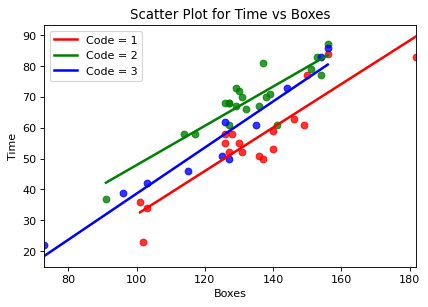

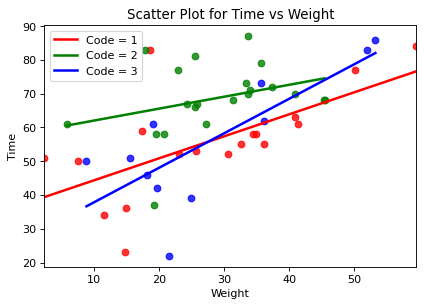

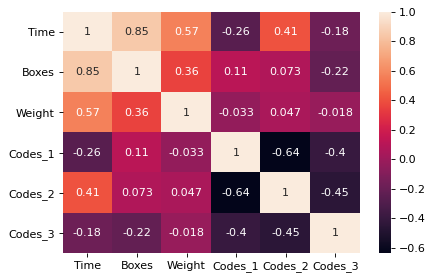

In [48]:
df18_19_c1 = df18_19_dummy[df18_19_dummy.Codes_1== 1]
df18_19_c2 = df18_19_dummy[df18_19_dummy.Codes_2== 1]
df18_19_c3 = df18_19_dummy[df18_19_dummy.Codes_3== 1]

for xname in df18_19.columns[1:3]:
    _ = sns.regplot(x=xname, y= 'Time', data = df18_19_c1, color = 'r', ci = None)
    _ = sns.regplot(x=xname, y= 'Time', data = df18_19_c2, color = 'g', ci = None)
    _ = sns.regplot(x=xname, y= 'Time', data = df18_19_c3, color = 'b', ci = None)
  
    plt.legend(labels=['Code = 1', 'Code = 2', 'Code = 3'])
    plt.title('Scatter Plot for Time vs '+xname)
    plt.xlabel(xname)
    plt.ylabel('Time')
    plt.show()
    
corr19_b = df18_19_dummy.corr()
_ = sns.heatmap(corr19_b, annot=True)

In [91]:
y_data = df18_19_dummy['Time']
X_data_ar = np.array([df18_19_dummy['Boxes'], df18_19_dummy['Weight'], df18_19_dummy['Codes_1'], df18_19_dummy['Codes_2']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df18_19_dummy.columns[1:5])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
df18_19_result2 = olsmod.fit()
print(df18_19_result2.summary())

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     197.7
Date:                Mon, 16 May 2022   Prob (F-statistic):           6.31e-28
Time:                        22:42:18   Log-Likelihood:                -135.30
No. Observations:                  50   AIC:                             280.6
Df Residuals:                      45   BIC:                             290.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.7180      3.727     -7.973      0.0

In [93]:
b4 = df18_19_result2.params[4]
b3 = df18_19_result2.params[3]
b2 = df18_19_result2.params[2]
b1 = df18_19_result2.params[1]
b0 = df18_19_result2.params[0]
print("\nEstimated model: y = %0.4f + %0.4f x1 + %0.4f x2 + %0.4f x3 + %0.4f x4" % (b0, b1, b2, b3,b4))


Estimated model: y = -29.7180 + 0.6177 x1 + 0.3464 x2 + -6.7556 x3 + 6.4800 x4


### (c) Assessment

In [16]:
print("standard error of 1st order = ", df18_19_result1.mse_resid ** 0.5)
print("standard error of 2nd order = ", df18_19_result2.mse_resid ** 0.5)
print('\n')
print("adjusted r^2  of 1st order = ", df18_19_result1.rsquared_adj)
print("adjusted r^2  of 2nd order = ", df18_19_result2.rsquared_adj)

standard error of 1st order =  6.249146409706934
standard error of 2nd order =  3.81788617976619


adjusted r^2  of 1st order =  0.8429024141996769
adjusted r^2  of 2nd order =  0.9413626864073111


The Indicator-variable model is better because its adjusted r^2 is higher and its standard error of estimate is smaller.

### (d)  
H0: Beta_3 = 0  
H1: Beta_3 != 0  
Since p-value of Code_1 = 0 < alpha = 0.05, we reject H0. There is enough evidence to infer that the average time to unload in the morning is different from others.  
H0: Beta_4 = 0  
H1: Beta_4 != 0  
Since p-value of Code_2 = 0 < alpha = 0.05, we reject H0. There is enough evidence to infer that the average time to unload in the early afternoon is different from others.

# 18.23 (12%) 
### 散佈圖3%，(a)3%，(b)3%，(c)3%  
Independent variable: Wage(X1), Pct PT(X2), Pct U(X3), Av Shift(X4), UM Rel(X5)       
Dependent variable (y): Absent  

In [50]:
df18_23 = pd.read_excel("Xr18-23.xlsx")
print('Dataset(head):')
display(df18_23.head())
print('Dataset(tail):')
display(df18_23.tail())

Dataset(head):


,Absent,Wage,Pct PT,Pct U,Av Shift,UM Rel
0,5.4,22477,8.5,57.1,1,1
1,4.1,29939,1.9,41.5,0,1
2,11.5,22957,12.2,52.6,1,0
3,2.1,18888,30.8,65.1,0,1
4,5.9,15078,6.8,68.8,0,1


Dataset(tail):


,Absent,Wage,Pct PT,Pct U,Av Shift,UM Rel
95,2.7,28878,7.4,12.2,1,1
96,8.0,24558,24.5,37.0,1,1
97,4.2,20447,0.9,27.4,1,1
98,9.0,27714,8.7,58.1,0,0
99,7.7,18116,3.5,47.5,1,1


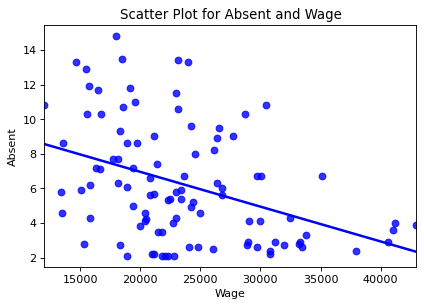

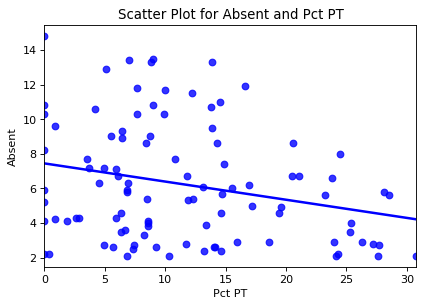

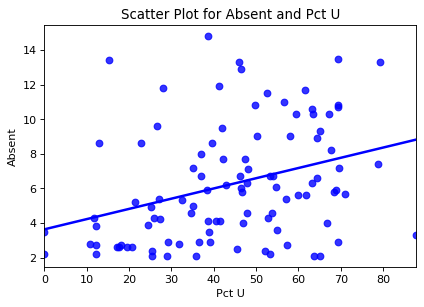

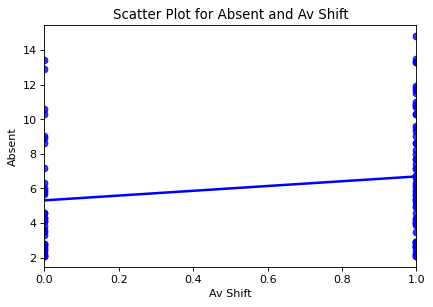

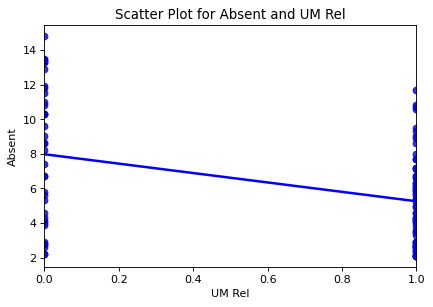

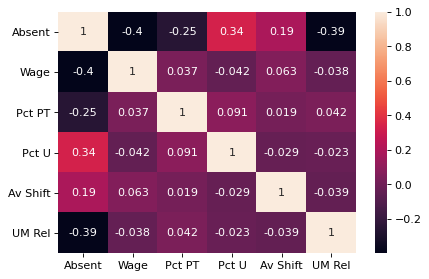

In [94]:
df18_23 = pd.read_excel("Xr18-23.xlsx")
scatter_plot(df18_23.columns[1:], "Absent", df18_23)
corr23 = df18_23.corr()
_ = sns.heatmap(corr23, annot=True)

### (a) Regression

In [95]:
y_data = df18_23['Absent']
X_data_ar = np.array([df18_23['Wage'], df18_23['Pct PT'], df18_23['Pct U'], df18_23['Av Shift'], df18_23['UM Rel']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df18_23.columns[1:])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
df18_23_result = olsmod.fit()
print(df18_23_result.summary())

                            OLS Regression Results                            
Dep. Variable:                 Absent   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     21.40
Date:                Mon, 16 May 2022   Prob (F-statistic):           3.08e-14
Time:                        22:47:09   Log-Likelihood:                -224.49
No. Observations:                 100   AIC:                             461.0
Df Residuals:                      94   BIC:                             476.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2648      1.172      8.756      0.0

In [97]:
b5 = df18_23_result.params[5]
b4 = df18_23_result.params[4]
b3 = df18_23_result.params[3]
b2 = df18_23_result.params[2]
b1 = df18_23_result.params[1]
b0 = df18_23_result.params[0]
print("\nEstimated model: y = %0.4f + %0.4f x1 + %0.4f x2 + %0.4f x3 + %0.4f x4 + %0.4f x5" % (b0, b1, b2, b3, b4, b5))


Estimated model: y = 10.2648 + -0.0002 x1 + -0.1069 x2 + 0.0599 x3 + 1.5619 x4 + -2.6366 x5


### (b)  
H0: Beta_4 = 0  
H1: Beta_4 != 0  
Since p-value of Av Shift  = .002 < alpha = 0.05, we reject H0. There is enough evidence to infer that the availability of shiftwork affects absenteeism.  
### (c)  
H0: Beta_5 = 0  
H1: Beta_5 < 0  
Since p-value of UM Rel  = 0/2 = 0 < alpha = 0.05, we reject H0. There is enough evidence to infer that in organizations where the union–management relationship is good absenteeism is lower.

# 18.36 (9) 
### 散佈圖3%，Regression Model 3%，Conclusion 3% (針對model去下結論)
X(independent variable) - Score(x1), Gender(x2)  
y(dependent variable) - Pay Rate

In [162]:
df18_36 = pd.read_excel('Pay Equity.xls')
df18_36 = df18_36.iloc[10:18, 1:4].reset_index(drop=True)
df18_36.columns = ['Pay Rate', 'Score', 'Gender']
print('Dataset(head):')
display(df18_36.head())
print('Dataset(tail):')
display(df18_36.tail())

Dataset(head):


,Pay Rate,Score,Gender
0,13.55,3.25,1
1,15.65,3.52,1
2,13.8,3.3,1
3,19.9,6.37,1
4,11.85,2.95,0


Dataset(tail):


,Pay Rate,Score,Gender
3,19.9,6.37,1
4,11.85,2.95,0
5,14.75,5.03,0
6,18.9,4.6,0
7,13.3,3.05,0


In [163]:
score = pd.read_excel('Pay Equity.xls')
score = score.iloc[2:7, 2:10]
score

,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
2,1,2,3,9,1,6,4,2
3,2,7,1,7,2,7,7,2
4,2,3,1,8,2,6,7,2
5,7,1,6,4,7,3,2,5
6,7,4,8,1,5,1,1,6


In [193]:
weight = [0.2, 0.2, 0.2, 0.2, 0.2]
s = score.values.T*weight
Weighted_score = s.sum(axis=1)

df18_36['Weighted_Score'] = Weighted_score
df18_36 = df18_36.astype(float)

print('Dataset(head):')
display(df18_36.head())
print('Dataset(tail):')
display(df18_36.tail())

Dataset(head):


,Pay Rate,Score,Gender,Weighted_Score
0,13.55,3.25,1.0,3.8
1,15.65,3.52,1.0,3.4
2,13.80,3.30,1.0,3.8
3,19.90,6.37,1.0,5.8
4,11.85,2.95,0.0,3.4


Dataset(tail):


,Pay Rate,Score,Gender,Weighted_Score
3,19.90,6.37,1.0,5.8
4,11.85,2.95,0.0,3.4
5,14.75,5.03,0.0,4.6
6,18.90,4.60,0.0,4.2
7,13.30,3.05,0.0,3.4


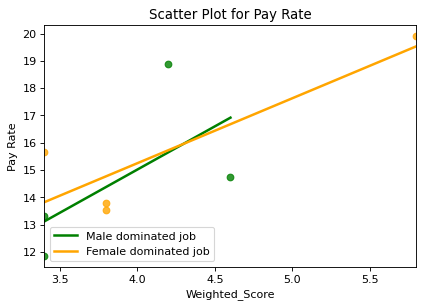

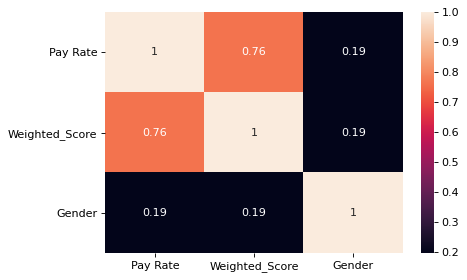

In [194]:
df18_36_G0 = df18_36[df18_36.Gender == 0]
df18_36_G1 = df18_36[df18_36.Gender == 1]

_ = sns.regplot(x='Weighted_Score', y= 'Pay Rate', data = df18_36_G0, color = 'green', ci = None)
_ = sns.regplot(x='Weighted_Score', y= 'Pay Rate', data = df18_36_G1, color = 'orange', ci = None)
plt.legend(labels=['Male dominated job', 'Female dominated job'])
plt.title('Scatter Plot for Pay Rate')
plt.xlabel('Weighted_Score')
plt.ylabel('Pay Rate')
plt.show()

corr36 = df18_36[["Pay Rate", "Weighted_Score", "Gender"]].corr()
_ = sns.heatmap(corr36, annot=True)

In [195]:
y = df18_36['Pay Rate']
xnames = ['Weighted_Score', 'Gender']
X_ar = np.array([df18_36['Weighted_Score'], df18_36['Gender']])
X_T =X_ar.T
X = pd.DataFrame(X_T,columns = xnames)
X = sm.add_constant(X)

olsmod = sm.OLS(y, X)
df18_23_result = olsmod.fit()
print(df18_23_result.summary())

                            OLS Regression Results                            
Dep. Variable:               Pay Rate   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     3.469
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.114
Time:                        23:12:13   Log-Likelihood:                -15.632
No. Observations:                   8   AIC:                             37.26
Df Residuals:                       5   BIC:                             37.50
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.6957      4.073      1.

In this case male–dominated jobs are paid on average $.255 (25.5 cents) more than female–dominated jobs after adjusting for the value of each job.

# 18.38 (12%) 
### 散佈圖3%，stepwise 3%，17.17 3%，compare 3%

In [59]:
df18_38 = pd.read_excel("Xr17-16.xlsx")
print('Dataset(head):')
display(df18_38.head())
print('Dataset(tail):')
display(df18_38.tail())

Dataset(head):


,DEFINITE,DAYS1,DAYS2,DAYS3,DAYS4,DAYS5,DAYS6
0,10,0,0,0,0,0,7
1,10,0,0,3,3,0,0
2,10,3,0,1,0,2,3
3,5,3,0,5,7,1,0
4,10,7,0,3,3,4,0


Dataset(tail):


,DEFINITE,DAYS1,DAYS2,DAYS3,DAYS4,DAYS5,DAYS6
887,10,5,5,5,6,0,0
888,5,7,7,0,1,0,0
889,10,5,5,0,0,0,0
890,10,7,5,7,0,0,5
891,8,4,7,0,0,0,0


DAYS1


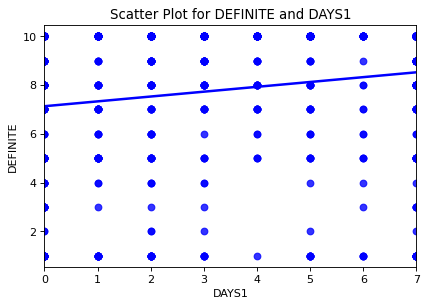

DAYS2


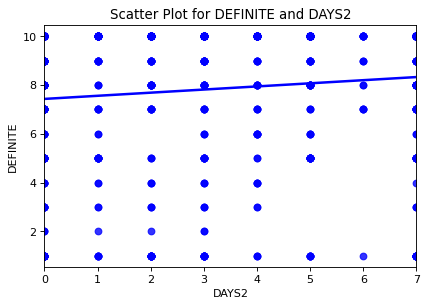

DAYS3


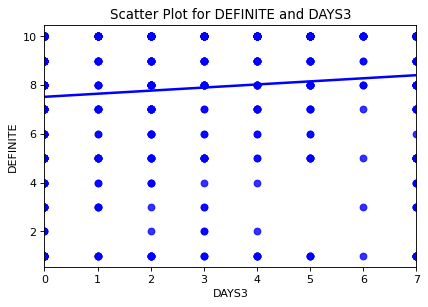

DAYS4


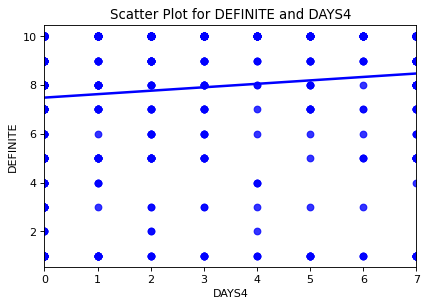

DAYS5


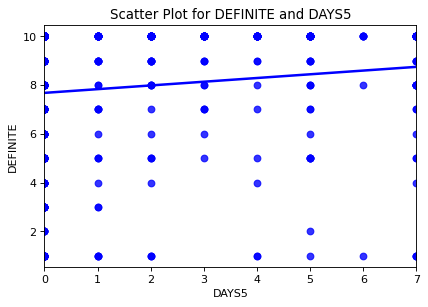

DAYS6


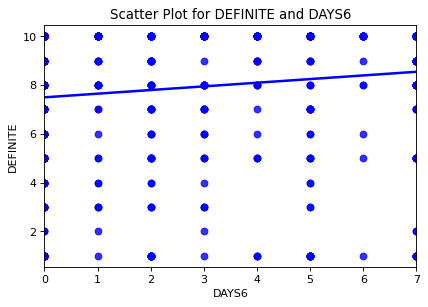

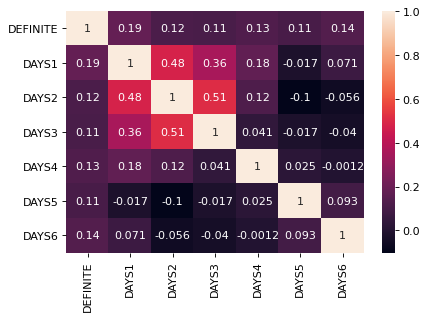

In [62]:
scatter_plot(df18_38.columns[1:], "DEFINITE", df18_38)

corr38 = df18_38.corr()
_ = sns.heatmap(corr38, annot=True)

In [67]:
df18_38_result = forward_selection(input_df = df18_38, depv = 'DEFINITE', indepv = df18_38.columns[1:])

Current Candidates:  Index(['DAYS1', 'DAYS2', 'DAYS3', 'DAYS4', 'DAYS5', 'DAYS6'], dtype='object')
Current best model:  ['DAYS1']
Current best AdjR2:  0.033572617717639086
Current Candidates:  ['DAYS6', 'DAYS3', 'DAYS4', 'DAYS2', 'DAYS5']
Current best model:  ['DAYS1', 'DAYS6']
Current best AdjR2:  0.04760823822379712
Current Candidates:  ['DAYS4', 'DAYS3', 'DAYS2', 'DAYS5']
Current best model:  ['DAYS1', 'DAYS6', 'DAYS4']
Current best AdjR2:  0.056642285730147734
Current Candidates:  ['DAYS3', 'DAYS2', 'DAYS5']
Current best model:  ['DAYS1', 'DAYS6', 'DAYS4', 'DAYS5']
Current best AdjR2:  0.06483946084093561
Current Candidates:  ['DAYS3', 'DAYS2']
Current best model:  ['DAYS1', 'DAYS6', 'DAYS4', 'DAYS5', 'DAYS3']
Current best AdjR2:  0.06766517784525938
Current Candidates:  ['DAYS2']
Current best model:  ['DAYS1', 'DAYS6', 'DAYS4', 'DAYS5', 'DAYS3', 'DAYS2']
Current best AdjR2:  0.06730270416755912
best_adjr2 =  0.06766517784525938
best_subset =  ['DAYS1', 'DAYS6', 'DAYS4', 'DAYS5', '

In [72]:
b5 = df18_38_result.params[5]
b4 = df18_38_result.params[4]
b3 = df18_38_result.params[3]
b2 = df18_38_result.params[2]
b1 = df18_38_result.params[1]
b0 = df18_38_result.params[0]
print("Estimated model: y = %0.4f + %0.4f DAYS1 + %0.4f DAY6 + %0.4f DAY4 + %0.4f DAY5 + %0.4f DAY3" % (b0, b1, b2, b3, b4, b5))

Estimated model: y = 6.4057 + 0.1470 DAYS1 + 0.1320 DAY6 + 0.1092 DAY4 + 0.1379 DAY5 + 0.0744 DAY3


In [68]:
y_data = df18_38['DEFINITE']
X_data_ar = np.array([df18_38['DAYS1'],df18_38['DAYS2'],df18_38['DAYS3'],df18_38['DAYS4'],df18_38['DAYS5'],df18_38['DAYS6'],])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df18_38.columns[1:])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
df18_38_result2 = olsmod.fit()
print(df18_38_result2.summary())

                            OLS Regression Results                            
Dep. Variable:               DEFINITE   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     11.72
Date:                Mon, 16 May 2022   Prob (F-statistic):           1.16e-12
Time:                        21:55:09   Log-Likelihood:                -2199.2
No. Observations:                 892   AIC:                             4412.
Df Residuals:                     885   BIC:                             4446.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3646      0.205     31.099      0.0

In [74]:
b6 = df18_38_result2.params[6]
b5 = df18_38_result2.params[5]
b4 = df18_38_result2.params[4]
b3 = df18_38_result2.params[3]
b2 = df18_38_result2.params[2]
b1 = df18_38_result2.params[1]
b0 = df18_38_result2.params[0]
print("Estimated model: y = %0.4f + %0.4f DAYS1 + %0.4f DAY2 + %0.4f DAY3 + %0.4f DAY4 + %0.4f DAY5 + %0.4f DAY6" % (b0, b1, b2, b3, b4, b5, b6))

Estimated model: y = 6.3646 + 0.1350 DAYS1 + 0.0363 DAY2 + 0.0601 DAY3 + 0.1074 DAY4 + 0.1419 DAY5 + 0.1341 DAY6


In this regression analysis the variables DAYS2 is not included in the equation.

# 18.49 (18%)
### 散佈圖3%，(a)(b)3%，(c)3%，(d)3%，(e)3%，(f)3%

In [179]:
df18_49 = pd.read_excel("Xr18-49.xlsx")
print('Dataset(head):')
display(df18_49.head())
print('Dataset(tail):')
display(df18_49.tail())

Dataset(head):


,Pct Dep,Temperature,PH Level,Weather
0,32.6,60,6.6,2
1,40.4,65,6.6,2
2,39.4,70,6.6,2
3,37.3,75,6.6,2
4,45.1,80,6.6,2


Dataset(tail):


,Pct Dep,Temperature,PH Level,Weather
205,33.6,70,8.4,1
206,34.9,75,8.4,1
207,36.4,80,8.4,1
208,34.8,85,8.4,1
209,42.6,90,8.4,1


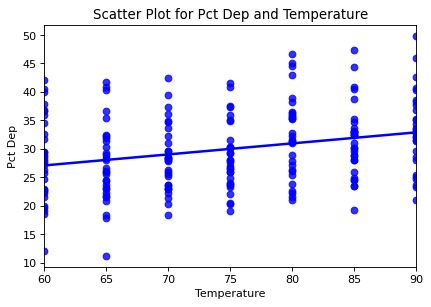

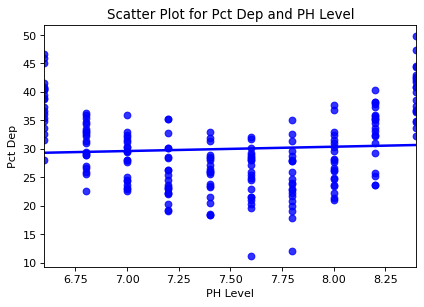

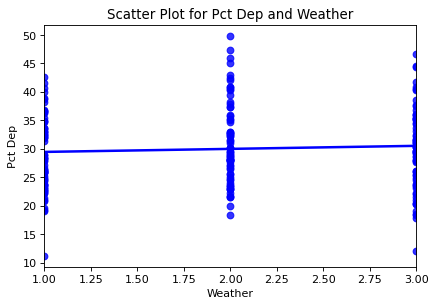

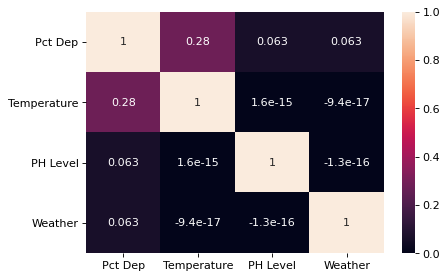

In [180]:
scatter_plot(df18_49.columns[1:], "Pct Dep", df18_49)

corr49 = df18_49.corr()
_ = sns.heatmap(corr49, annot=True)

It seems to be a parabola between PH Level and Pct Dep, we apply second order model.  


In [181]:
df18_49['PH Level'] = df18_49['PH Level']-df18_49['PH Level'].mean()
df18_49['PH Level2'] = df18_49['PH Level'] **2
print('Dataset(head):')
display(df18_49.head())
print('Dataset(tail):')
display(df18_49.tail())

Dataset(head):


,Pct Dep,Temperature,PH Level,Weather,PH Level2
0,32.6,60,-0.9,2,0.81
1,40.4,65,-0.9,2,0.81
2,39.4,70,-0.9,2,0.81
3,37.3,75,-0.9,2,0.81
4,45.1,80,-0.9,2,0.81


Dataset(tail):


,Pct Dep,Temperature,PH Level,Weather,PH Level2
205,33.6,70,0.9,1,0.81
206,34.9,75,0.9,1,0.81
207,36.4,80,0.9,1,0.81
208,34.8,85,0.9,1,0.81
209,42.6,90,0.9,1,0.81


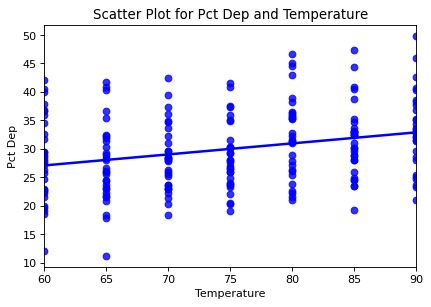

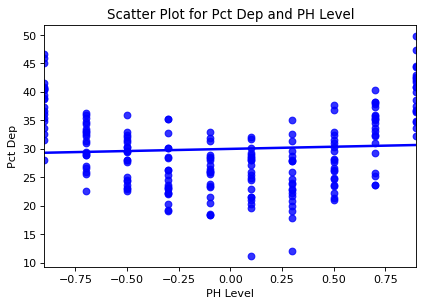

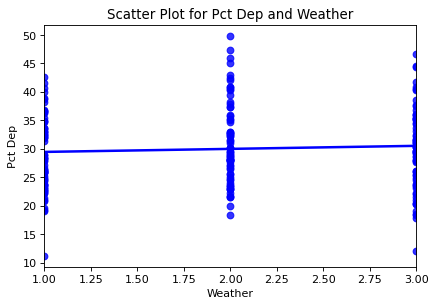

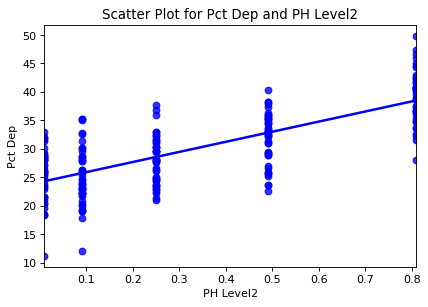

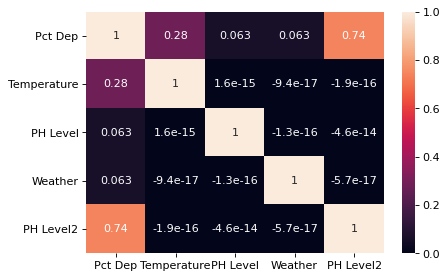

In [182]:
scatter_plot(df18_49.columns[1:], "Pct Dep", df18_49)

corr49_b = df18_49.corr()
_ = sns.heatmap(corr49_b, annot=True)

In [183]:
df18_49_dummy = pd.get_dummies(df18_49, columns = ["Weather"])
print('Dataset(head):')
display(df18_49_dummy.head())
print('Dataset(tail):')
display(df18_49_dummy.tail())

Dataset(head):


,Pct Dep,Temperature,PH Level,PH Level2,Weather_1,Weather_2,Weather_3
0,32.6,60,-0.9,0.81,0,1,0
1,40.4,65,-0.9,0.81,0,1,0
2,39.4,70,-0.9,0.81,0,1,0
3,37.3,75,-0.9,0.81,0,1,0
4,45.1,80,-0.9,0.81,0,1,0


Dataset(tail):


,Pct Dep,Temperature,PH Level,PH Level2,Weather_1,Weather_2,Weather_3
205,33.6,70,0.9,0.81,1,0,0
206,34.9,75,0.9,0.81,1,0,0
207,36.4,80,0.9,0.81,1,0,0
208,34.8,85,0.9,0.81,1,0,0
209,42.6,90,0.9,0.81,1,0,0


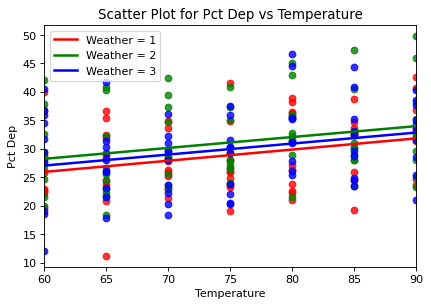

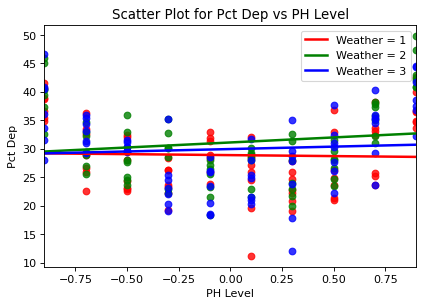

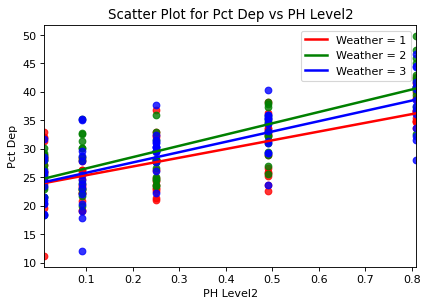

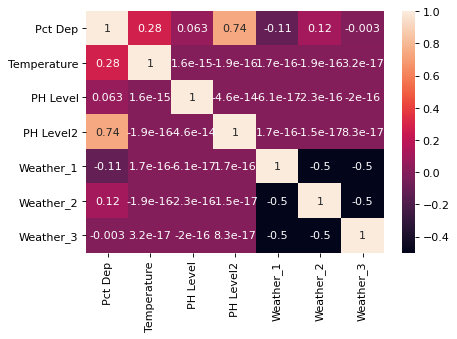

In [186]:
df18_49_w1 = df18_49_dummy[df18_49_dummy.Weather_1== 1]
df18_49_w2 = df18_49_dummy[df18_49_dummy.Weather_2== 1]
df18_49_w3 = df18_49_dummy[df18_49_dummy.Weather_3== 1]

for xname in df18_49_dummy.columns[1:4]:
    _ = sns.regplot(x=xname, y= 'Pct Dep', data = df18_49_w1, color = 'r', ci = None)
    _ = sns.regplot(x=xname, y= 'Pct Dep', data = df18_49_w2, color = 'g', ci = None)
    _ = sns.regplot(x=xname, y= 'Pct Dep', data = df18_49_w3, color = 'b', ci = None)
  
    plt.legend(labels=['Weather = 1', 'Weather = 2', 'Weather = 3'])
    plt.title('Scatter Plot for Pct Dep vs '+xname)
    plt.xlabel(xname)
    plt.ylabel('Pct Dep')
    plt.show()
    
corr49_b = df18_49_dummy.corr()
_ = sns.heatmap(corr49_b, annot=True)

Independent variable: Temperature(X1), PH Level(X2), PH Level2(X3), Weather_1(X4), Weather_2(X5)       
Dependent variable (y): Pct Dep

In [187]:
y_data = df18_49_dummy['Pct Dep']
X_data_ar = np.array([df18_49_dummy['Temperature'], df18_49_dummy['PH Level'], df18_49_dummy['PH Level2'], df18_49_dummy['Weather_1'], df18_49_dummy['Weather_2']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = ['Temperature', 'PH Level', 'PH Level2', 'Weather_1', 'Weather_2'])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
df18_49_result = olsmod.fit()
print(df18_49_result.summary())

                            OLS Regression Results                            
Dep. Variable:                Pct Dep   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     77.00
Date:                Wed, 18 May 2022   Prob (F-statistic):           4.50e-45
Time:                        04:49:18   Log-Likelihood:                -593.23
No. Observations:                 210   AIC:                             1198.
Df Residuals:                     204   BIC:                             1219.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.5692      2.222      4.306      

In [188]:
b5 = df18_49_result.params[5]
b4 = df18_49_result.params[4]
b3 = df18_49_result.params[3]
b2 = df18_49_result.params[2]
b1 = df18_49_result.params[1]
b0 = df18_49_result.params[0]
print("Estimated model: y = %0.4f + %0.4f x1 + %0.4f x2 + %0.4f x3 + %0.4f x4  + %0.4f x5 " % (b0, b1, b2, b3, b4, b5))

Estimated model: y = 9.5692 + 0.1938 x1 + 0.7571 x2 + 17.7579 x3 + -1.0686 x4  + 1.1571 x5 


### (c)
H0: All betas = 0  
H1: At least one of the betas != 0  
Since F = 5.648, p-value = 0 < alpha = 0.05, we reject H0. The model is valid.  
### (d)
H0: beta_1 = 0  
H1: beta_1 > 0  
Since pvalue of temperature = 0/2 = 0 <alpha = 0.05, we reject H0.  
There is enough evidence to infer that higher temperatures deplete chlorine more quickly.  
### (e)
H0: beta_3 = 0  
H1: beta_3 > 0  
Since pvalue of HP Level2 = 0/2 < alpha = 0.05, we do not reject H0.  
There is enough evidence to infer that there is a quadratic relationship between chlorine depletion and PH level.  
### (f)
H0: beta_4 = 0  
H1: beta_4 != 0  
Since pvalue of Weather 1 = 0.128 > alpha = 0.05, we do not reject H0.  
H0: beta_5 = 0   
H1: beta_5 != 0   
Since pvalue of Weather 2 = 0.100 > alpha = 0.05, we do not reject H0.  
There is not enough evidence to infer that chlorine depletion differs between weathers.  